In [68]:
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

In [69]:
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

%matplotlib inline

In [70]:
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim
from rnn import StochasticLSTM

In [71]:
plt.style.use("fivethirtyeight")

In [72]:
df = web.DataReader('AAPL', data_source='yahoo', start='2012-01-01', end='2019-12-17')
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,58.928570,58.428570,58.485714,58.747143,75555200.0,50.994907
2012-01-04,59.240002,58.468571,58.571430,59.062859,65005500.0,51.268970
2012-01-05,59.792858,58.952858,59.278572,59.718571,67817400.0,51.838169
2012-01-06,60.392857,59.888573,59.967144,60.342857,79573200.0,52.380054
2012-01-09,61.107143,60.192856,60.785713,60.247143,98506100.0,52.296970
...,...,...,...,...,...,...
2019-12-11,271.100006,268.500000,268.809998,270.769989,19689200.0,270.128906
2019-12-12,272.559998,267.320007,267.779999,271.459991,34327600.0,270.817261
2019-12-13,275.299988,270.929993,271.459991,275.149994,33396900.0,274.498535


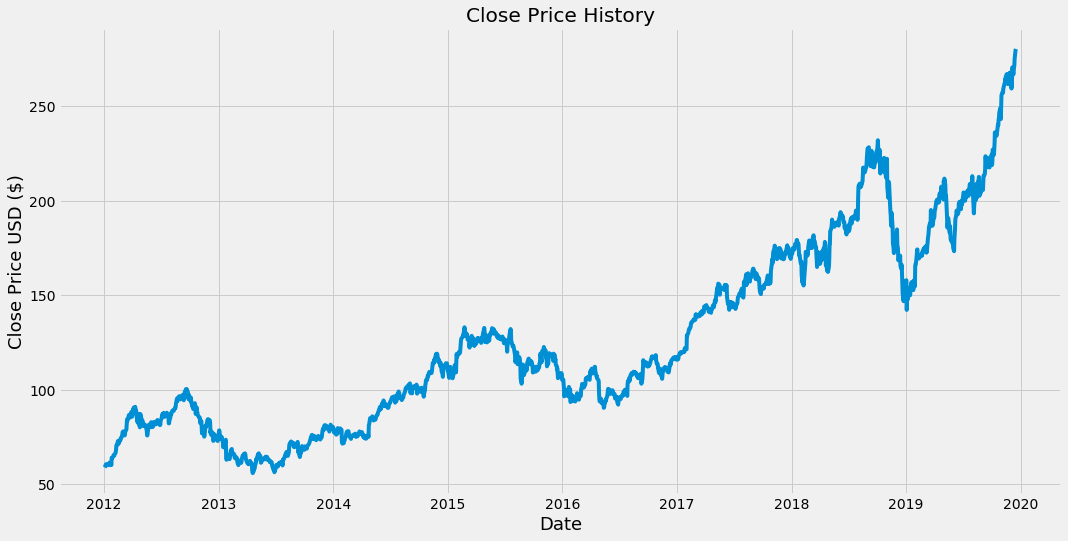

In [73]:
plt.figure(figsize=(16, 8))
plt.title("Close Price History")
plt.plot(df["Close"])
plt.xlabel("Date", fontsize=18)
plt.ylabel("Close Price USD ($)", fontsize=18)
plt.show()

In [74]:
data = df.filter(["Close"])
dataset = data.values
training_data_len = math.ceil(len(dataset) * .8)

training_data_len

1603

In [75]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.01316509],
       [0.01457064],
       [0.01748985],
       ...,
       [0.97658263],
       [0.99755134],
       [1.        ]])

In [76]:
STEP = 60

In [77]:
train_data = scaled_data[0:training_data_len, :]

x_train = np.array([train_data[i-STEP:i, 0] for i in range(STEP, training_data_len)])
y_train = np.array([train_data[i, 0] for i in range(STEP, training_data_len)])

In [78]:
ENTRY_COUNT = len(y_train)

In [79]:
x_train = x_train.reshape(ENTRY_COUNT, STEP, 1)
x_train.shape

(1543, 60, 1)

In [80]:
raw_dataset = [(x_train[i], y_train[i]) for i in range(ENTRY_COUNT)]
traindl = torch.utils.data.DataLoader(raw_dataset, shuffle=True, batch_size=2, num_workers=2)

In [81]:
class DropoutMSELoss():
    def __init__(self, length_scale, precision, dropout):
        super(DropoutMSELoss, self).__init__()
        self.loss = nn.MSELoss()
        self.length_scale = length_scale
        self.precision = precision
        self.dropout = dropout
    
    def __call__(self, outputs, labels, named_params, N):
        named_params = [p for p in named_params]
        M = 0.5 * self.length_scale**2 * self.dropout / self.precision / N * \
            torch.norm(
                torch.cat([p.view(-1) for name, p in named_params if name.endswith("weight")]),
                2
            )
        m = 0.5 * self.length_scale**2 / self.precision / N * \
            torch.norm(
                torch.cat([p.view(-1) for name, p in named_params if name.endswith("bias")]),
                2
            )
        return self.loss(outputs, labels) + M + m

In [82]:
dropout_rate = 0.0

In [83]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.rnn = StochasticLSTM(1, 50, dropout_rate=dropout_rate)
        self.fc1 = nn.Linear(50, 25)
        self.fc2 = nn.Linear(25, 1)
    
    def forward(self, x):
        result, _ = self.rnn(x)
        result = result[-1,:]
        result = self.fc1(result)
        result = self.fc2(result)
        return result

In [84]:
net = Net().double()
criterion = DropoutMSELoss(1, 1, dropout_rate)
optimizer = optim.Adam(net.parameters(), lr=0.0001)

In [85]:
for epoch in range(10):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(traindl):
        optimizer.zero_grad()
        outputs = net(inputs.transpose(1, 0))
        loss = criterion(outputs.flatten(), labels.double(), net.rnn.named_parameters(), 1543)
        loss.backward()
        optimizer.step()
    
        # print statistics
        running_loss += loss.item()
        if i % 300 == 299:
            print('[%d, %5d] loss: %.6f' %
                  (epoch + 1, i + 1, running_loss / 300))
            running_loss = 0.0

print("Finish training")

[1,   300] loss: 0.031399
[1,   600] loss: 0.016472
[2,   300] loss: 0.004040
[2,   600] loss: 0.003118
[3,   300] loss: 0.002879
[3,   600] loss: 0.002804
[4,   300] loss: 0.002732
[4,   600] loss: 0.002747
[5,   300] loss: 0.002652
[5,   600] loss: 0.002679
[6,   300] loss: 0.002574
[6,   600] loss: 0.002550
[7,   300] loss: 0.002493
[7,   600] loss: 0.002498
[8,   300] loss: 0.002431
[8,   600] loss: 0.002343
[9,   300] loss: 0.002281
[9,   600] loss: 0.002314
[10,   300] loss: 0.002242
[10,   600] loss: 0.002221
Finish training


In [86]:
test_data = scaled_data[training_data_len - 60:, :]
x_test = torch.tensor([test_data[i-60:i, 0] for i in range(60, len(test_data))])
y_test = dataset[training_data_len:,:]
x_test = x_test.reshape(len(x_test), STEP, 1)

In [87]:
predictions = net(x_test.transpose(1, 0))
predictions = scaler.inverse_transform(predictions.detach().numpy())

In [88]:
rmse = np.sqrt(np.mean((predictions-y_test)**2))
rmse

17.75716894913314

/usr/local/miniconda3/envs/master-thesis/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


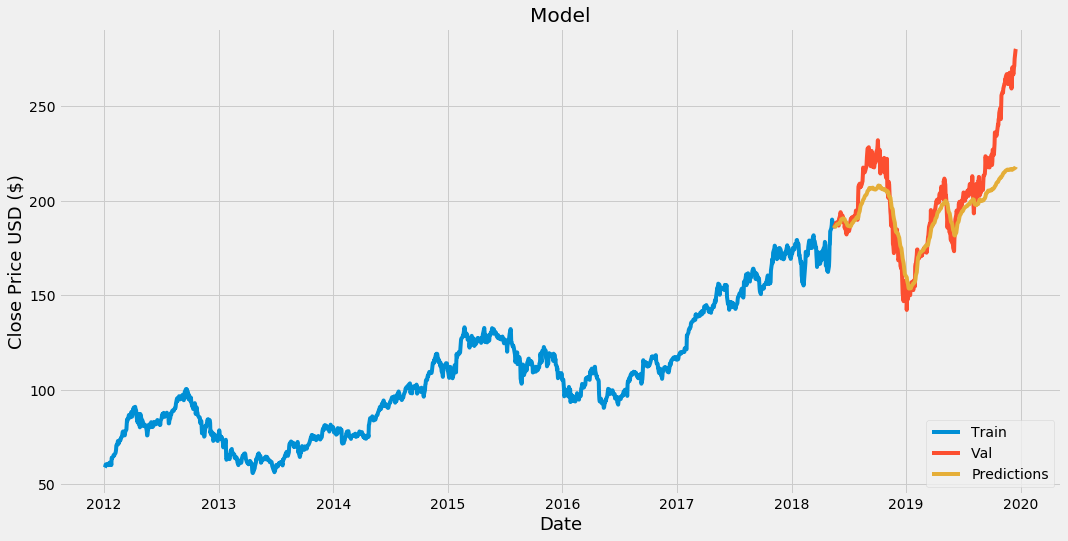

In [89]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

plt.figure(figsize=(16, 8))
plt.title("Model")
plt.xlabel("Date", fontsize=18)
plt.ylabel("Close Price USD ($)", fontsize=18)
plt.plot(train["Close"])
plt.plot(valid[["Close", "Predictions"]])
plt.legend(["Train", "Val", "Predictions"], loc="lower right")
plt.show()

In [90]:
valid

,Close,Predictions
Date,,
2018-05-17,186.990005,185.535978
2018-05-18,186.309998,186.074063
2018-05-21,187.630005,186.384144
2018-05-22,187.160004,186.695774
2018-05-23,188.360001,186.961314
...,...,...
2019-12-11,270.769989,217.002204
2019-12-12,271.459991,217.173615
2019-12-13,275.149994,217.319939
